# Simultaneous pixelated source and smooth lens modeling
### Fit the source light as a regularised grid of pixels along as parameters of the smooth lens model (SIE + shear)
The true source is an elliptical Sérsic profile here, but can be anything.

__last updated__: 30/07/21

In [1]:
# Basic imports
from time import time
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline
plt.rc('image', interpolation='none')

# Basic JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

# OPTAX
import optax

# jaxtronomy imports
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters
from jaxtronomy.Inference.loss import Loss
from jaxtronomy.Inference.optimization import Optimizer
from jaxtronomy.Inference.sampling import Sampler
from jaxtronomy.Util import image_util
from jaxtronomy.Util.jax_util import WaveletTransform

# Universal font size
FS = 18

np.random.seed(18)

### Data grids (image plane and source plane)
For simplicity at first, assume both share the same pixelization.

In [2]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


### Source light model

In [3]:
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'e1': -0.09, 'e2': 0.03,
                        'center_x': 0.4, 'center_y': 0.15}]

### Lens model (SIE + external shear)

In [4]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR']
lens_mass_model = LensModel(lens_mass_model_list)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

### PSF

In [5]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

### Noise

In [6]:
exp_time = None
sigma_bkd = 0.01
noise_map = sigma_bkd * np.ones((npix, npix))
kwargs_noise = {'background_rms': sigma_bkd, 'exposure_time': exp_time}
noise = Noise(npix, npix, **kwargs_noise)

### Image model

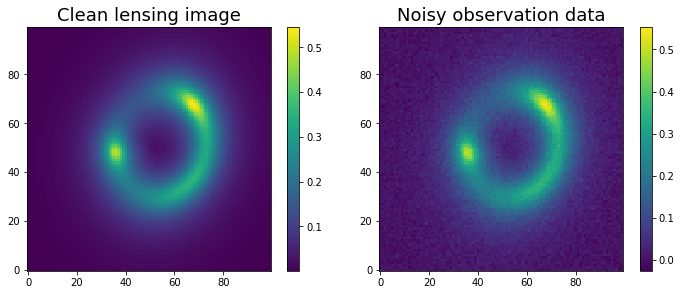

In [7]:
# Generate a lensed image based on source and lens models
kwargs_numerics = {'supersampling_factor': 3, 'supersampling_convolution': False}
lens_image = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         kwargs_numerics=kwargs_numerics)

image = lens_image.model(kwargs_lens=kwargs_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light)

source_true = lens_image.source_surface_brightness(kwargs_source=kwargs_source_light, 
                                                   de_lensed=True, unconvolved=True)

# Observed noisy data
data = lens_image.simulation(kwargs_lens=kwargs_lens_mass,
                              kwargs_source=kwargs_source_light,
                              kwargs_lens_light=kwargs_lens_light)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower')
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower')
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

## Source fitting on a pixelated grid with starlet regularisation

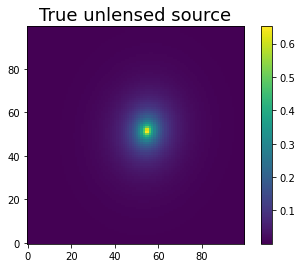

In [8]:
# Visualise the true source
fig, ax = plt.subplots(1, 1)
img = ax.imshow(source_true, origin='lower')
ax.set_title("True unlensed source", fontsize=FS)
fig.colorbar(img)

### Create a model for fitting

In [9]:
# Recreate a Noise object with true noise map
kwargs_noise_fit = {'background_rms': sigma_bkd, 'noise_map': noise_map}
fit_noise = Noise(npix, npix, **kwargs_noise_fit)

# Change only the source light model
fit_source_light_model_list = ['PIXELATED']
fit_source_light_model = LightModel(fit_source_light_model_list)
fit_lens_image = LensImage(pixel_grid, psf, noise_class=fit_noise,
                             lens_model_class=lens_mass_model,
                             source_model_class=fit_source_light_model,
                             lens_light_model_class=lens_light_model,
                             kwargs_numerics=kwargs_numerics)

# 1D coordinate arrays for source grid interpolation
x_coords = fit_lens_image.Data.pixel_coordinates[0][0, :]
y_coords = fit_lens_image.Data.pixel_coordinates[1][:, 0]

In [10]:
kwargs_model = {
    'lens_model_list': lens_mass_model_list,
    'source_model_list': fit_source_light_model_list,
    'lens_light_model_list': lens_light_model_list,
}
kwargs_init = {
    'kwargs_lens': [{'theta_E': 1.5, 'e1': 0.1, 'e2': -0.05, 'center_x': 1e-3, 'center_y': 1e-3}, {'gamma1': -0.02, 'gamma2': 0.02}],
    #'kwargs_source': [{'image': 1e-8 * jnp.ones_like(source_true)}],
    'kwargs_source': [{'image': jnp.array(source_true)}],
}
kwargs_prior = {
    'kwargs_lens': [{'theta_E': ['uniform', 1.5, 1.7], 'e1': ['uniform', -0.1, 0.1], 'e2': ['uniform', -0.1, 0.1]}, {'gamma1': ['uniform', -0.1, 0.1], 'gamma2': ['uniform', -0.1, 0.1]}],
    'kwargs_source': [{'image': ['uniform', 0.*jnp.ones_like(source_true), 10.*jnp.ones_like(source_true)]}],
}
kwargs_fixed = {
    'kwargs_lens': [{'center_x': 0., 'center_y': 0.}, {'ra_0': 0., 'dec_0': 0.}],
    #'kwargs_lens': kwargs_lens_mass,  # uncomment this to fix all lens parameters
    'kwargs_source': [{
        'x_coords': jnp.asarray(x_coords), 
        'y_coords': jnp.asarray(y_coords),
    }],
}
parameters = Parameters(kwargs_model, kwargs_init, kwargs_prior, kwargs_fixed)

kwargs_true = {
    'kwargs_lens': kwargs_lens_mass, 
    'kwargs_source': [{'image': source_true, 'x_coords': x_coords, 'y_coords': y_coords}]
}
p_true = parameters.kwargs2args(kwargs_true)
p_init = parameters.kwargs2args(kwargs_init)
print("truths:", len(p_true), parameters.names[0], parameters.names[-1])

print(parameters.prior_types[0])
print(parameters.bounds)
#print(parameters.log_prior(parameters.initial_values()))

truths: 10005 theta_E s_9999
uniform
(array([ 1.5, -0.1, -0.1, ...,  0. ,  0. ,  0. ]), array([ 1.7,  0.1,  0.1, ..., 10. , 10. , 10. ]))


### Loss function

In [11]:
loss = Loss(data, fit_lens_image, parameters, 
            likelihood_type='l2_norm',
            regularization_terms=['l1_starlet_source', 
                                  'l1_battle_source',
                                  'positivity_source'], 
            regularization_strengths=[(5, 3), 3, 3],
            prior_terms=None)

# JIT the loss gradient function
grad_loss = jax.jit(jax.grad(loss))

In [12]:
print(p_true.shape)
print(f"loss at init: {loss(p_init):.2f}")
print(f"loss at truth: {loss(p_true):.2f}")
#print(f"grad(loss): {jax.jit(jax.grad(loss))(p_true)}")

#plt.imshow(np.sqrt(loss._image.Noise.C_D), origin='lower')
#plt.colorbar()
#plt.show()

(10005,)
loss at init: 3.93
loss at truth: 1.57


In [13]:
def plot_source_reconstruction(p_result, loss_history=None):
    kwargs_result = parameters.args2kwargs(p_result)
    s_result = kwargs_result['kwargs_source'][0]['image']

    rec_f = fit_lens_image.model(**kwargs_result)  # truth

    # Image plane reconstruction
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    ax1, ax2, ax3 = axes[0, :]
    img1 = ax1.imshow(data, origin='lower')
    ax1.set_title("Data", fontsize=FS)
    img2 = ax2.imshow(rec_f, origin='lower')
    ax2.set_title("Final lensed image", fontsize=FS)
    img3 = ax3.imshow((data - rec_f) / noise_map, origin='lower', vmin=-4, vmax=4, cmap='RdBu_r')
    ax3.set_title("Normalised residual", fontsize=FS)
    chi2 = jnp.mean((data - rec_f)**2 / fit_lens_image.Noise.C_D)
    ax3.set_xlabel(f"Chi-sq : {chi2:.2f}")
    for img, ax in zip((img1, img2, img3), axes[0, :]):
        fig.colorbar(img, ax=ax)
    #fig.tight_layout()

    # Source plane reconstruction
    #fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    ax1, ax2, ax3 = axes[1, :]
    vmax = source_true.max()
    img1 = ax1.imshow(source_true, origin='lower') #, vmax=vmax)
    ax1.set_title("True unlensed source", fontsize=FS)
    img2 = ax2.imshow(s_result, origin='lower') #, vmax=vmax)
    ax2.set_title("Regularised source", fontsize=FS)

    img3 = ax3.imshow(source_true - s_result, origin='lower', vmin=-vmax/10., vmax=vmax/10., cmap='RdBu_r')
    ax3.set_title("Absolute error", fontsize=FS)
    for img, ax in zip((img1, img2, img3), axes[1, :]):
        fig.colorbar(img, ax=ax)
    fig.tight_layout()

### Optimize parameters with `optax`

In [14]:
# Max number of iterations
n_iter = 100

# Global learning rate (or initial value when decaying)
learning_rate = 1e-2

# Exponential decay of the learning rate
scheduler = optax.exponential_decay(
    init_value=learning_rate, 
    transition_steps=n_iter,
    decay_rate=0.99)

# Combining gradient transforms using `optax.chain`
optimizer_custom = optax.chain(
    #optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm
    optax.scale_by_belief(),  # Use the updates from an optimizer
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler
    optax.scale(-1.)  # because gradient *descent*
)

params = jnp.array(p_init)
opt_state = optimizer_custom.init(params)

start_time = time()

# A simple update loop.
for _ in range(n_iter):
    updates, opt_state = optimizer_custom.update(grad_loss(params), opt_state, params)
    params = optax.apply_updates(params, updates)
    
print(f"Runtime: {time() - start_time:0.2f} s")

p_final_optax = params
print("Final loss : {:.2f}".format(loss(p_final_optax)))

Runtime: 15.00 s
Final loss : 2.84


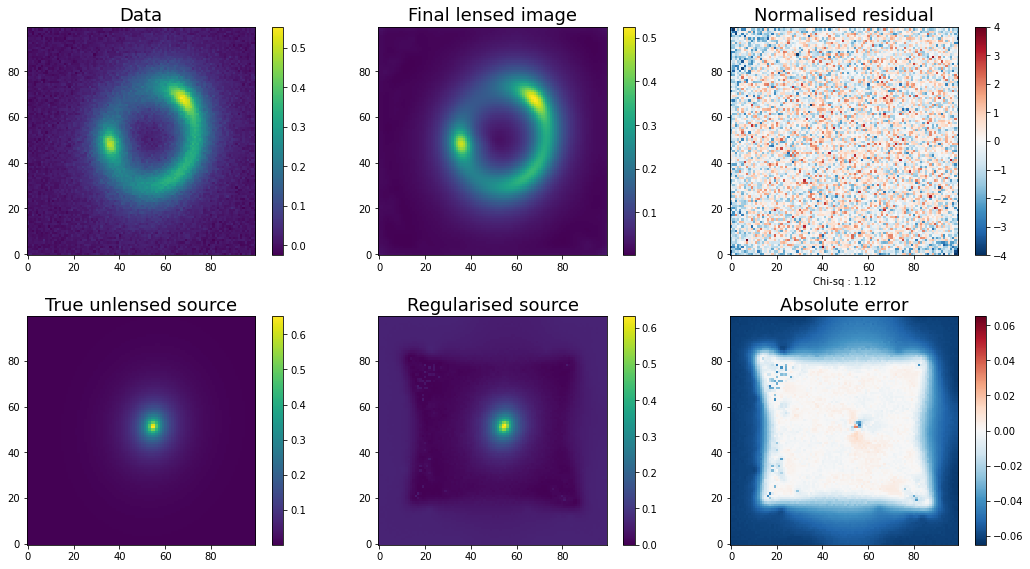

In [15]:
plot_source_reconstruction(p_final_optax)

In [16]:
def print_errors(kwargs):
    def _print_error(name, value, estimate):
        spaces = " " * (10 - len(name))
        if value != 0:
            error = 100 * abs(value - estimate) / value
            print(name + ":" + spaces + f"{error:.2f} % ({value} => {estimate})")
        else:
            error = abs(value - estimate)
            print(name + ":" + spaces + f"{error:.2f} [abs] ({value} => {estimate})")
    print("Error")
    print("-----")
    for i, params in enumerate(kwargs_lens_mass):
        for key, value in params.items():
            fit = kwargs['kwargs_lens'][i][key]
            _print_error(key, value, fit)
        
print_errors(parameters.args2kwargs(p_final_optax))

Error
-----
theta_E:   0.29 % (1.6 => 1.6045604796957833)
e1:        7.55 % (0.15 => 0.13867666132524611)
e2:        -32.53 % (-0.04 => -0.05301092064403191)
center_x:  0.00 [abs] (0.0 => 0.0)
center_y:  0.00 [abs] (0.0 => 0.0)
gamma1:    -61.68 % (-0.01 => -0.016167955225439387)
gamma2:    32.02 % (0.03 => 0.020392735725348894)
ra_0:      0.00 [abs] (0.0 => 0.0)
dec_0:     0.00 [abs] (0.0 => 0.0)
